In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

import env

# Acquire Zillow Data

- Acquire data from mySQL using the python module to connect and query
- Single dataframe
- Including logerror 

In [2]:
# Using env file to import user, password and hostname allowing access to SQL database
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/zillow'

# SQL Query will be used to retrieve data from SQL Database 
query= '''
	SELECT prop.*,
		   pred.logerror,
		   pred.transactiondate,	
		   cons.typeconstructiondesc,
		   air.airconditioningdesc,
		   arch.architecturalstyledesc,
		   build.buildingclassdesc,
		   land.propertylandusedesc,		
		   story.storydesc
	FROM properties_2017 prop
		INNER JOIN(SELECT parcelid, logerror, MAX(transactiondate)transactiondate
					FROM predictions_2017
					GROUP BY parcelid, logerror) pred
				USING (parcelid)
		LEFT JOIN typeconstructiontype cons USING (typeconstructiontypeid)
		LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
		LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
		LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
		LEFT JOIN propertylandusetype land USING (propertylandusetypeid)
		LEFT JOIN storytype story USING (storytypeid)
	WHERE prop.latitude IS NOT NULL
		AND prop.longitude IS NOT NULL
		AND transactiondate LIKE '2017%%';
'''


### Assign data to a variable, verify import by calling df.head()

In [3]:
df = pd.read_sql(query, url)
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxdelinquencyyear,censustractandblock,logerror,transactiondate,typeconstructiondesc,airconditioningdesc,architecturalstyledesc,buildingclassdesc,propertylandusedesc,storydesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,NaN,6.059063e+13,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,NaN,6.111001e+13,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,NaN,6.059022e+13,0.005383,2017-01-01,None,None,None,None,Single Family Residential,None
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,NaN,6.037300e+13,-0.103410,2017-01-01,None,None,None,None,Single Family Residential,None
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,NaN,6.037124e+13,0.006940,2017-01-01,None,Central,None,None,Condominium,None


### Copy dataframe into CSV file for faster access

In [4]:
df.to_csv('zillow.csv', index=False)

### Create a function for faster access and reproducibility


In [5]:
# Make a function to call get the data from mysql
def get_db_url(database):
    from env import host, user, password
    url = f'mysql+pymysql://{user}:{password}@{host}/{database}'
    return url

# Make a function to look for a cache zillow or get it from mysql
def get_zillow_data():    
	
	'''This function will acquire data from zillow using env file and rename the columns before saving it as CSV'''

	filename = 'zillow.csv'
	if os.path.exists(filename):
		print('Reading from csv file...')
		return pd.read_csv(filename)
    
	query = '''
        SELECT prop.*,
	    	   pred.logerror,
		       pred.transactiondate,	
    		   cons.typeconstructiondesc,
	    	   air.airconditioningdesc,
		       arch.architecturalstyledesc,
    		   build.buildingclassdesc,
	    	   land.propertylandusedesc,		
		       story.storydesc
    	FROM properties_2017 prop
	    	INNER JOIN(SELECT parcelid, logerror, MAX(transactiondate)transactiondate
		    			FROM predictions_2017
			    		GROUP BY parcelid, logerror) pred
				    USING (parcelid)
    		LEFT JOIN typeconstructiontype cons USING (typeconstructiontypeid)
	    	LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
		    LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
    		LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
	    	LEFT JOIN propertylandusetype land USING (propertylandusetypeid)
		    LEFT JOIN storytype story USING (storytypeid)
	    WHERE prop.latitude IS NOT NULL
		    AND prop.longitude IS NOT NULL
    		AND transactiondate LIKE '2017%%';
    '''
	
	print('Getting a fresh copy from SQL database...')
	df = pd.read_sql(query, get_db_url('zillow'))
	
	# transfer dataframe into a csv for faster access
	print('Saving to csv...')
	df.to_csv(filename, index=False)
	return df

#### Verify function works

In [6]:
df = get_zillow_data()

Reading from csv file...


## Wrangle Zillow Data
Check the information of the dataframe by running:

- df.head() to check what is
- df.info() to look at the counts and dtypes
- df.isnull() to check for nulls
- df.describe() to see all the stats

In [7]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxdelinquencyyear,censustractandblock,logerror,transactiondate,typeconstructiondesc,airconditioningdesc,architecturalstyledesc,buildingclassdesc,propertylandusedesc,storydesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,NaN,6.037124e+13,0.006940,2017-01-01,NaN,Central,NaN,NaN,Condominium,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77574 entries, 0 to 77573
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77574 non-null  int64  
 1   parcelid                      77574 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77574 non-null  float64
 6   bedroomcnt                    77574 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49808 non-null  float64
 9   calculatedbathnbr             76959 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77374 non-null  float64
 13  f

In [9]:
df.shape

(77574, 67)

In [10]:
df.isnull().sum()

id                              0
parcelid                        0
airconditioningtypeid       52568
architecturalstyletypeid    77368
basementsqft                77524
                            ...  
airconditioningdesc         52568
architecturalstyledesc      77368
buildingclassdesc           77559
propertylandusedesc             0
storydesc                   77524
Length: 67, dtype: int64

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,77574.0,1.495340e+06,8.609689e+05,3.490000e+02,7.520875e+05,1.498169e+06,2.240588e+06,2.982274e+06
parcelid,77574.0,1.300630e+07,3.478043e+06,1.071186e+07,1.153819e+07,1.253050e+07,1.421124e+07,1.676893e+08
airconditioningtypeid,25006.0,1.812045e+00,2.965823e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,206.0,7.388350e+00,2.734542e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77574.0,2.298521e+00,9.967057e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77574.0,3.053252e+00,1.140447e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49808.0,6.533830e+00,1.722041e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76959.0,2.316389e+00,9.796902e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01


In [12]:
df [df.columns[(df.dtypes != 'O')]]

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,6.059063e+13,0.025595
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,6.111001e+13,0.055619
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,6.059022e+13,0.005383
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,6.037300e+13,-0.103410
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,6.037124e+13,0.006940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,2864704,10833991,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,NaN,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,6.037132e+13,-0.002245
77570,673515,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,6.037101e+13,0.020615
77571,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,...,1.0,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,6.111008e+13,0.013209
77572,1843709,12773139,1.0,NaN,NaN,1.0,3.0,NaN,4.0,1.0,...,NaN,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,6.037434e+13,0.037129


### Visualize data

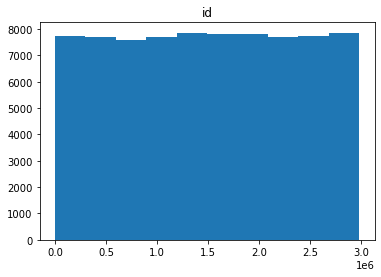

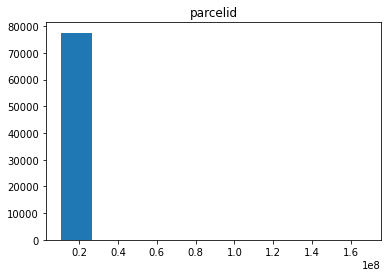

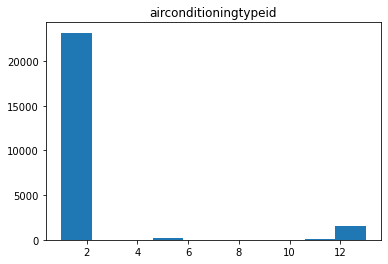

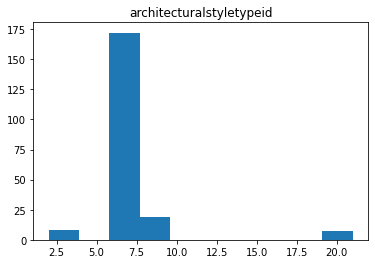

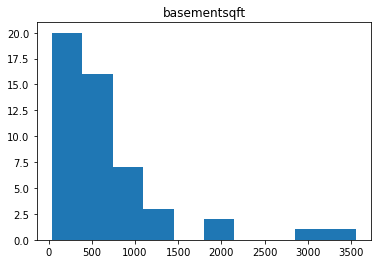

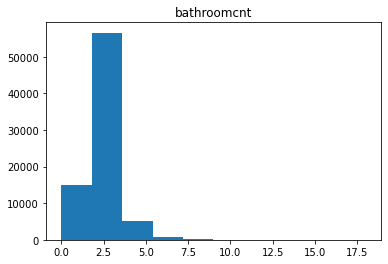

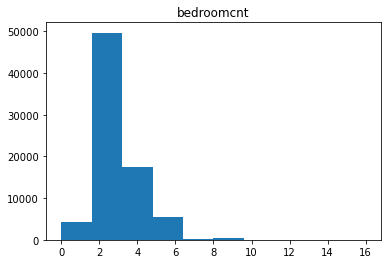

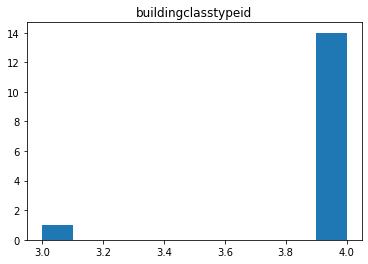

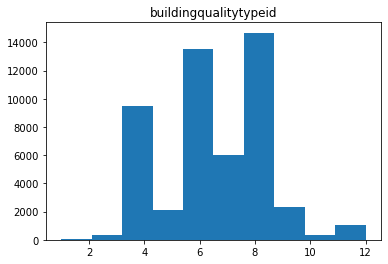

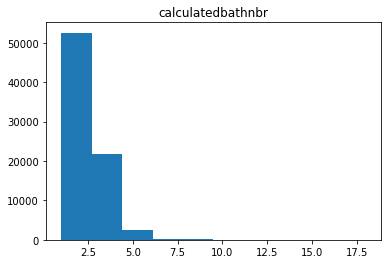

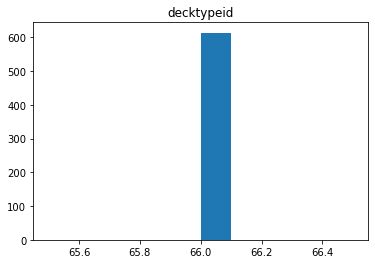

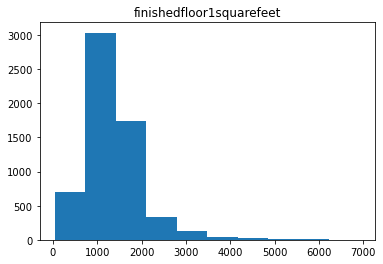

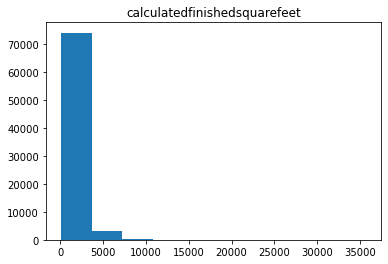

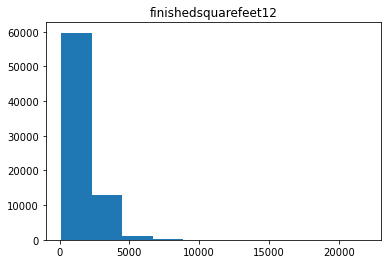

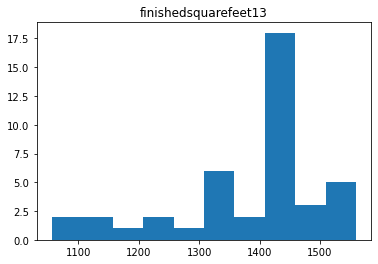

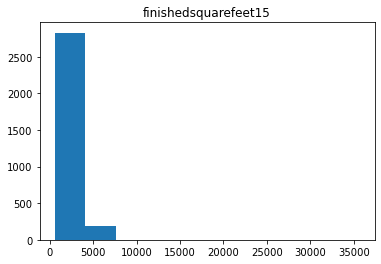

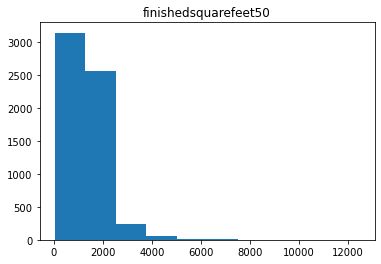

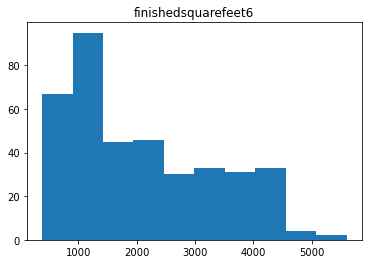

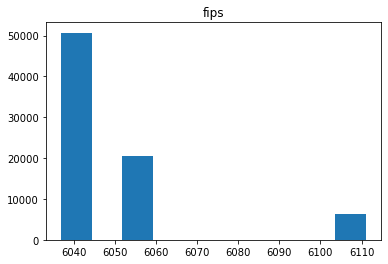

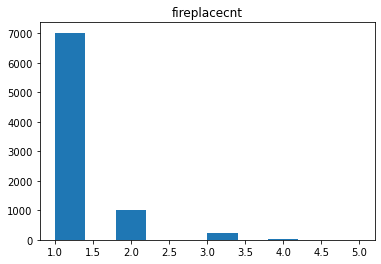

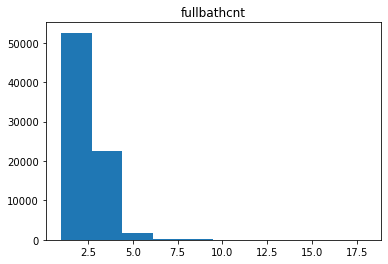

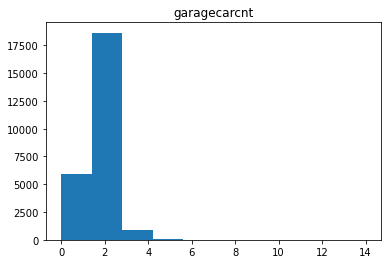

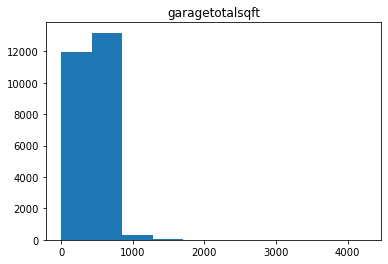

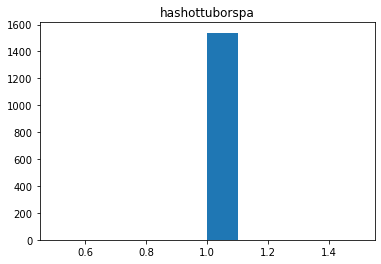

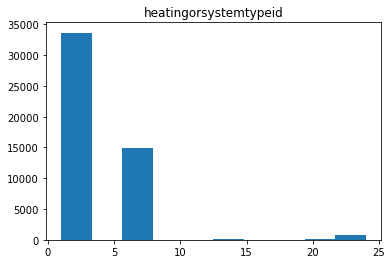

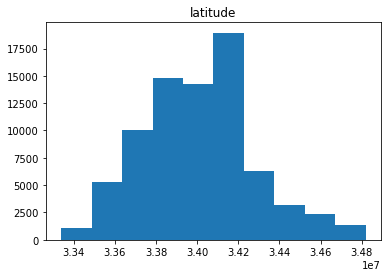

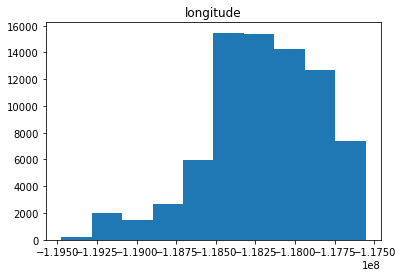

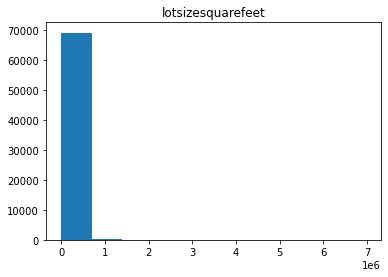

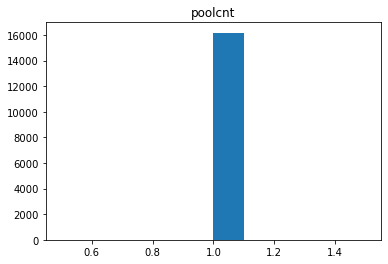

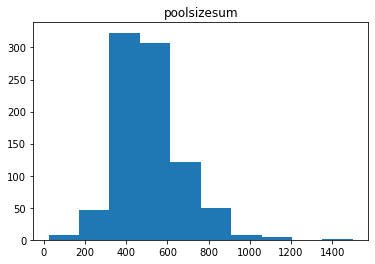

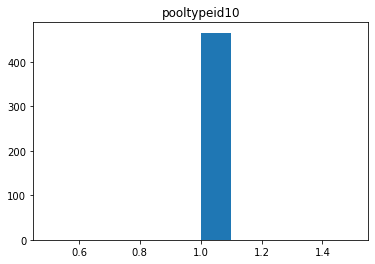

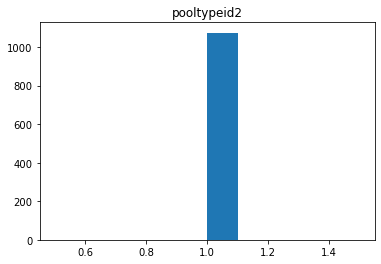

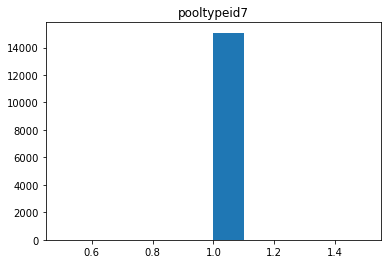

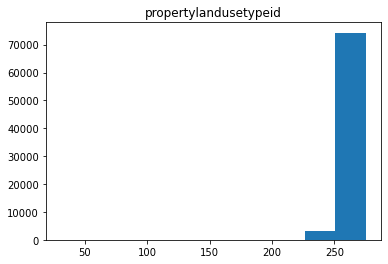

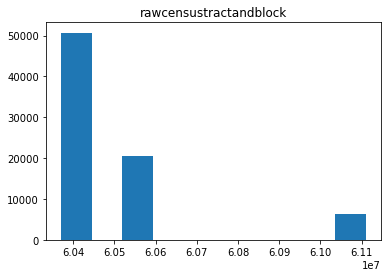

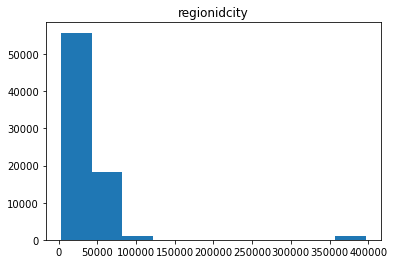

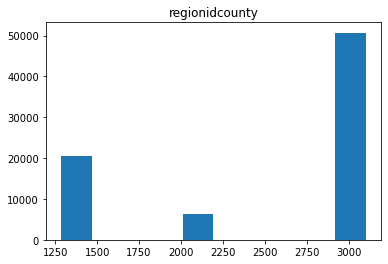

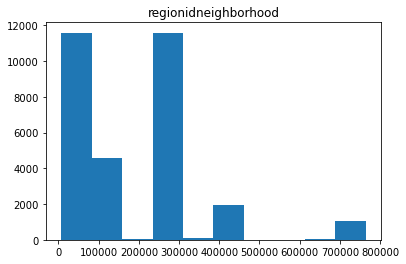

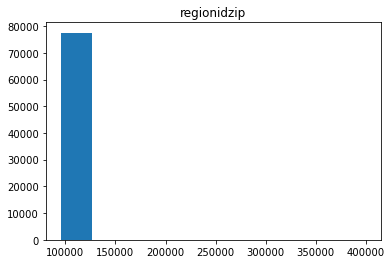

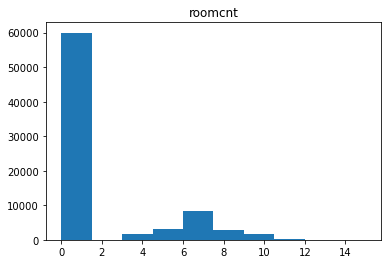

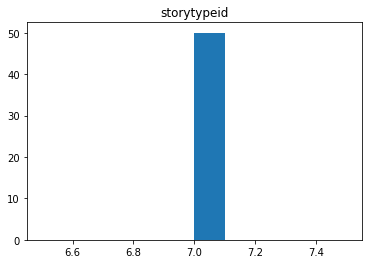

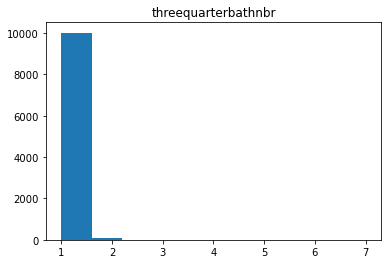

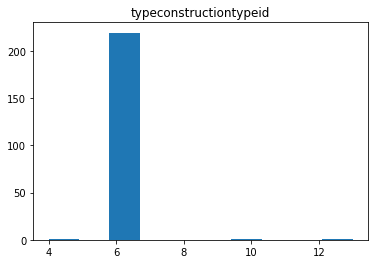

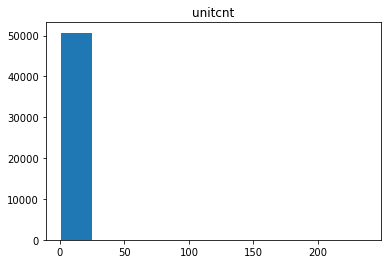

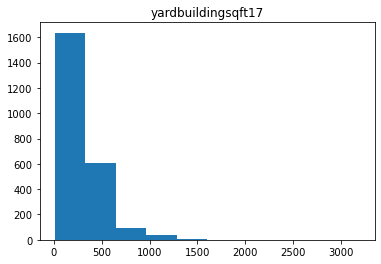

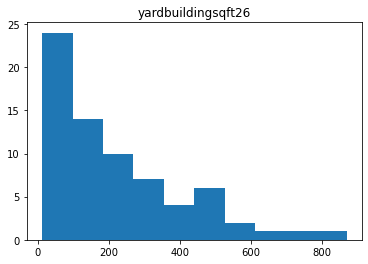

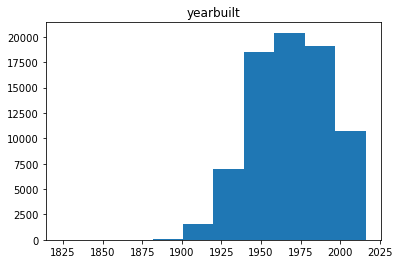

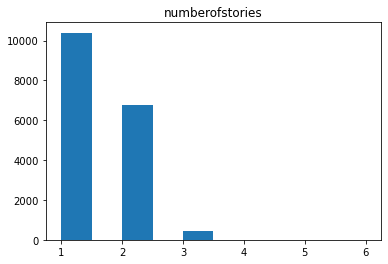

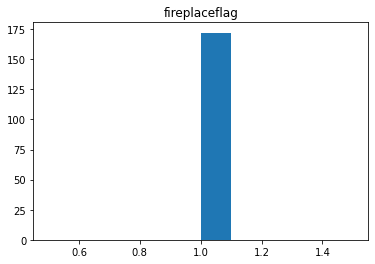

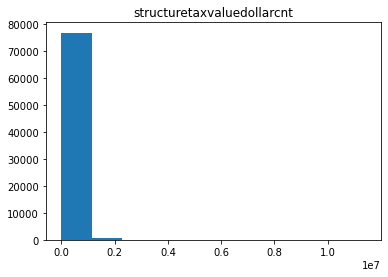

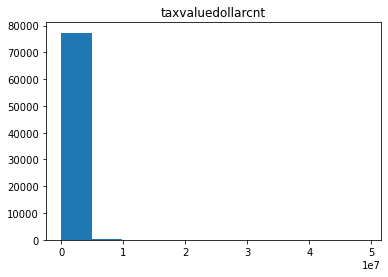

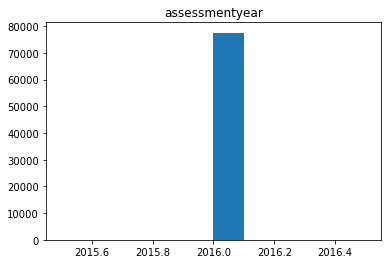

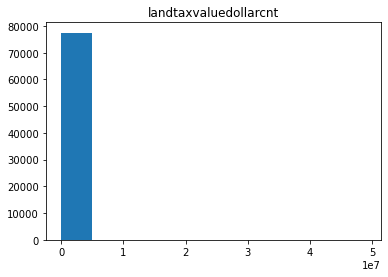

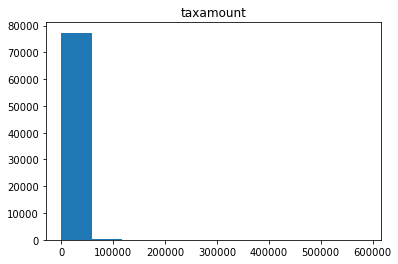

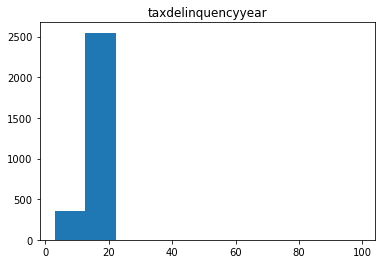

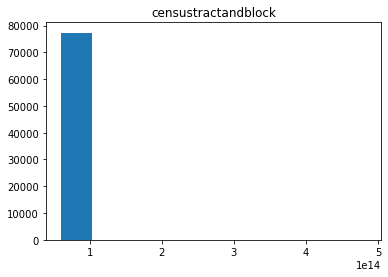

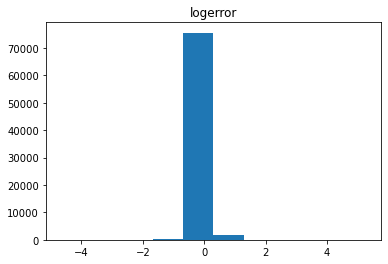

In [13]:
# List of columns
cols = df [df.columns[(df.dtypes != 'O')]]


for col in cols:
   
    # Title with columns name.
    plt.title(col)
    # histogram of each column 
    plt.hist(df[col])
    plt.show()

In [14]:
obj_cols =df [df.columns[(df.dtypes == 'O')]]
obj_cols

,propertycountylandusecode,propertyzoningdesc,taxdelinquencyflag,transactiondate,typeconstructiondesc,airconditioningdesc,architecturalstyledesc,buildingclassdesc,propertylandusedesc,storydesc
0,122,NaN,NaN,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
1,1110,NaN,NaN,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
2,122,NaN,NaN,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
3,0101,LCR110000*,NaN,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
4,010C,LAR3,NaN,2017-01-01,NaN,Central,NaN,NaN,Condominium,NaN
...,...,...,...,...,...,...,...,...,...,...
77569,010C,LARD3,NaN,2017-09-20,NaN,Central,NaN,NaN,Condominium,NaN
77570,0100,LARE40,NaN,2017-09-20,NaN,NaN,NaN,NaN,Single Family Residential,NaN
77571,1111,NaN,NaN,2017-09-21,NaN,NaN,NaN,NaN,Single Family Residential,NaN
77572,0100,SER1*,NaN,2017-09-21,NaN,Central,NaN,NaN,Single Family Residential,NaN


In [15]:
for col in obj_cols:
    print(col)
    print(df[col].value_counts())
    print('------------------------')

propertycountylandusecode
0100    26781
122     13067
010C     8838
0101     6413
34       4931
        ...  
0115        1
0131        1
1432        1
040G        1
020E        1
Name: propertycountylandusecode, Length: 75, dtype: int64
------------------------
propertyzoningdesc
LAR1         6766
LAR3         2449
LARS         1394
LBR1N        1225
LARD1.5      1132
             ... 
LCCM*           1
BFA16000*       1
LCPR*           1
LYR2            1
BFA15000*       1
Name: propertyzoningdesc, Length: 1907, dtype: int64
------------------------
taxdelinquencyflag
Y    2900
Name: taxdelinquencyflag, dtype: int64
------------------------
transactiondate
2017-06-30    1194
2017-04-28     917
2017-05-31     868
2017-07-28     815
2017-08-31     782
              ... 
2017-03-12       1
2017-07-22       1
2017-08-05       1
2017-08-06       1
2017-09-25       1
Name: transactiondate, Length: 264, dtype: int64
------------------------
typeconstructiondesc
Frame       219
Masonry      

### Get the Single Unit / Single family homes.

In [16]:
df.propertylandusetypeid.value_counts()

261.0    52438
266.0    19341
246.0     2021
269.0     1947
248.0      729
247.0      539
265.0      335
263.0       74
275.0       59
260.0       41
267.0       29
31.0        15
264.0        6
Name: propertylandusetypeid, dtype: int64

In [17]:
df.propertylandusedesc.value_counts()

Single Family Residential                     52438
Condominium                                   19341
Duplex (2 Units, Any Combination)              2021
Planned Unit Development                       1947
Quadruplex (4 Units, Any Combination)           729
Triplex (3 Units, Any Combination)              539
Cluster Home                                    335
Mobile Home                                      74
Manufactured, Modular, Prefabricated Homes       59
Residential General                              41
Cooperative                                      29
Commercial/Office/Residential Mixed Used         15
Townhouse                                         6
Name: propertylandusedesc, dtype: int64

In [18]:
single_fam = [260, 261, 263, 266, 264, 275]
df = df[df.propertylandusetypeid.isin(single_fam)]

In [19]:
df.propertylandusedesc.value_counts()

Single Family Residential                     52438
Condominium                                   19341
Mobile Home                                      74
Manufactured, Modular, Prefabricated Homes       59
Residential General                              41
Townhouse                                         6
Name: propertylandusedesc, dtype: int64

In [20]:
df.isnull().sum().sort_values(ascending=False)[:45]

buildingclasstypeid         71959
buildingclassdesc           71959
finishedsquarefeet15        71948
finishedsquarefeet13        71917
storydesc                   71912
basementsqft                71912
storytypeid                 71912
yardbuildingsqft26          71889
finishedsquarefeet6         71792
fireplaceflag               71787
architecturalstyletypeid    71753
architecturalstyledesc      71753
typeconstructiondesc        71737
typeconstructiontypeid      71737
pooltypeid10                71495
decktypeid                  71368
poolsizesum                 71090
pooltypeid2                 70885
hashottuborspa              70421
yardbuildingsqft17          69693
taxdelinquencyflag          69342
taxdelinquencyyear          69342
finishedfloor1squarefeet    66261
finishedsquarefeet50        66261
fireplacecnt                63857
threequarterbathnbr         61961
pooltypeid7                 57292
poolcnt                     56200
numberofstories             54912
airconditionin

### Takeaways:
- lots of null values
- multiple columns with very liitle input
- outliers are skewing charts

# Prepare

### Look up null values

In [21]:
# get the numbers of rows missinig per column
num_rows_missing = df.isnull().sum()
# 3500 is a little more than 50% 
[num_rows_missing[(num_rows_missing > 40000) == True]]

[airconditioningtypeid       48881
 architecturalstyletypeid    71753
 basementsqft                71912
 buildingclasstypeid         71959
 decktypeid                  71368
 finishedfloor1squarefeet    66261
 finishedsquarefeet13        71917
 finishedsquarefeet15        71948
 finishedsquarefeet50        66261
 finishedsquarefeet6         71792
 fireplacecnt                63857
 garagecarcnt                46955
 garagetotalsqft             46955
 hashottuborspa              70421
 poolcnt                     56200
 poolsizesum                 71090
 pooltypeid10                71495
 pooltypeid2                 70885
 pooltypeid7                 57292
 regionidneighborhood        43693
 storytypeid                 71912
 threequarterbathnbr         61961
 typeconstructiontypeid      71737
 yardbuildingsqft17          69693
 yardbuildingsqft26          71889
 numberofstories             54912
 fireplaceflag               71787
 taxdelinquencyflag          69342
 taxdelinquencyyear 

In [22]:
# get the number of rows to calculate percentage
num_rows = df.shape[0]
num_rows

71959

In [23]:
# Calculate percent of missing
pct_rows_missing = num_rows_missing/num_rows
# display number of rows with more than 70% missing
pct_rows_missing[pct_rows_missing >.7]

architecturalstyletypeid    0.997137
basementsqft                0.999347
buildingclasstypeid         1.000000
decktypeid                  0.991787
finishedfloor1squarefeet    0.920816
finishedsquarefeet13        0.999416
finishedsquarefeet15        0.999847
finishedsquarefeet50        0.920816
finishedsquarefeet6         0.997679
fireplacecnt                0.887408
hashottuborspa              0.978627
poolcnt                     0.781000
poolsizesum                 0.987924
pooltypeid10                0.993552
pooltypeid2                 0.985075
pooltypeid7                 0.796176
storytypeid                 0.999347
threequarterbathnbr         0.861060
typeconstructiontypeid      0.996915
yardbuildingsqft17          0.968510
yardbuildingsqft26          0.999027
numberofstories             0.763101
fireplaceflag               0.997610
taxdelinquencyflag          0.963632
taxdelinquencyyear          0.963632
typeconstructiondesc        0.996915
architecturalstyledesc      0.997137
b

In [24]:
# Make dataframe
pd.DataFrame({'number_missing_rows': num_rows_missing, 'percent_rows_missing': pct_rows_missing})

,number_missing_rows,percent_rows_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,48881,0.679290
architecturalstyletypeid,71753,0.997137
basementsqft,71912,0.999347
...,...,...
airconditioningdesc,48881,0.679290
architecturalstyledesc,71753,0.997137
buildingclassdesc,71959,1.000000
propertylandusedesc,0,0.000000


### Create a function to get nulls by column for future use

In [25]:
def nulls_by_col(df):
    num_rows_missing = df.isnull().sum()
    pct_rows_missing = num_rows_missing/num_rows
    df_missing = pd.DataFrame({'number_missing_rows': num_rows_missing, 'percent_rows_missing': pct_rows_missing})
    return df_missing
    

In [26]:
# test the function
nulls_by_col(df)

,number_missing_rows,percent_rows_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,48881,0.679290
architecturalstyletypeid,71753,0.997137
basementsqft,71912,0.999347
...,...,...
airconditioningdesc,48881,0.679290
architecturalstyledesc,71753,0.997137
buildingclassdesc,71959,1.000000
propertylandusedesc,0,0.000000


### Look up nulls by rows 

In [27]:
# get the numner of rows missing values and sort by number nulls
df.isna().sum(axis = 1).value_counts()

33    13401
34    13250
32    12732
31    10754
35     5608
29     5202
30     3715
36     3331
37     2045
28      612
27      494
38      251
39      173
26      129
43       79
44       50
25       34
42       26
41       26
40       21
24       14
23        4
45        4
47        2
46        2
dtype: int64

In [28]:
# Create a dataframe to hold the number of columns missing and the number of rows missing
col_missing = pd.DataFrame(df.isna().sum(axis =1), columns = ['num_cols_missing']).reset_index().groupby('num_cols_missing')
col_missing = col_missing.count().reset_index().rename(columns = {'index': 'num_rows'})
col_missing

,num_cols_missing,num_rows
0,23,4
1,24,14
2,25,34
3,26,129
4,27,494
5,28,612
6,29,5202
7,30,3715
8,31,10754
9,32,12732


In [29]:
# add a column calculating the percentage 
col_missing['pct_cols_missing'] = col_missing.num_cols_missing/df.shape[1]
col_missing

,num_cols_missing,num_rows,pct_cols_missing
0,23,4,0.343284
1,24,14,0.358209
2,25,34,0.373134
3,26,129,0.388060
4,27,494,0.402985
5,28,612,0.417910
6,29,5202,0.432836
7,30,3715,0.447761
8,31,10754,0.462687
9,32,12732,0.477612


### Create a function for future use

In [30]:
def nulls_by_row(df):
    miss_df = pd.DataFrame(df.isna().sum(axis =1), columns = ['num_cols_missing']).reset_index().groupby('num_cols_missing')
    miss_df = miss_df.count().reset_index().rename(columns = {'index': 'num_rows' })
   
    miss_df['pct_cols_missing'] = miss_df.num_cols_missing/df.shape[1]
   
    return miss_df

In [31]:
# Test the function
nulls_by_row(df)

,num_cols_missing,num_rows,pct_cols_missing
0,23,4,0.343284
1,24,14,0.358209
2,25,34,0.373134
3,26,129,0.388060
4,27,494,0.402985
5,28,612,0.417910
6,29,5202,0.432836
7,30,3715,0.447761
8,31,10754,0.462687
9,32,12732,0.477612


### Drop columns that have greater than 50% nulls

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71959 entries, 0 to 77573
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            71959 non-null  int64  
 1   parcelid                      71959 non-null  int64  
 2   airconditioningtypeid         23078 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   71959 non-null  float64
 6   bedroomcnt                    71959 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         45078 non-null  float64
 9   calculatedbathnbr             71682 non-null  float64
 10  decktypeid                    591 non-null    float64
 11  finishedfloor1squarefeet      5698 non-null   float64
 12  calculatedfinishedsquarefeet  71767 non-null  float64
 13  f

### Create a function that will drop rows or columns based on the percent of values that are missing. 

This will allow us to drop columns with the percentage we want, let's try rows and columns that are missing 50%.

In [33]:
def handle_missing_values(df, prop_required_column = .5, prop_required_row = .5):
    '''
    function that will drop rows or columns based on the 
    percent of values that are missing
    '''
    n_required_column = round(df.shape[0] * prop_required_column)
    n_required_row = round(df.shape[1] * prop_required_row)
    df = df.dropna(axis=0, thresh=n_required_row)
    df = df.dropna(axis=1, thresh=n_required_column)
    return df   

In [34]:
# Assign it a different variable to compare
df1 = handle_missing_values(df)
df1.shape, df.shape

((47091, 30), (71959, 67))

#### Compare info, describe, nulls by row, and nulls by column

In [35]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47091 entries, 1 to 77572
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            47091 non-null  int64  
 1   parcelid                      47091 non-null  int64  
 2   bathroomcnt                   47091 non-null  float64
 3   bedroomcnt                    47091 non-null  float64
 4   calculatedbathnbr             47082 non-null  float64
 5   calculatedfinishedsquarefeet  47090 non-null  float64
 6   finishedsquarefeet12          47071 non-null  float64
 7   fips                          47091 non-null  float64
 8   fullbathcnt                   47082 non-null  float64
 9   heatingorsystemtypeid         36047 non-null  float64
 10  latitude                      47091 non-null  float64
 11  longitude                     47091 non-null  float64
 12  lotsizesquarefeet             44798 non-null  float64
 13  p

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71959 entries, 0 to 77573
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            71959 non-null  int64  
 1   parcelid                      71959 non-null  int64  
 2   airconditioningtypeid         23078 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   71959 non-null  float64
 6   bedroomcnt                    71959 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         45078 non-null  float64
 9   calculatedbathnbr             71682 non-null  float64
 10  decktypeid                    591 non-null    float64
 11  finishedfloor1squarefeet      5698 non-null   float64
 12  calculatedfinishedsquarefeet  71767 non-null  float64
 13  f

In [37]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
id,47091.0,1.492611e+06,8.627121e+05,3.490000e+02,7.470960e+05,1.494660e+06,2.240076e+06,2.982188e+06
parcelid,47091.0,1.272907e+07,2.384948e+06,1.071186e+07,1.122521e+07,1.206889e+07,1.389292e+07,1.629608e+08
bathroomcnt,47091.0,2.377057e+00,9.926356e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,47091.0,3.071181e+00,1.051462e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01
calculatedbathnbr,47082.0,2.377512e+00,9.921862e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
calculatedfinishedsquarefeet,47090.0,1.854487e+03,1.015471e+03,1.520000e+02,1.216000e+03,1.592000e+03,2.205000e+03,2.192900e+04
finishedsquarefeet12,47071.0,1.854641e+03,1.015441e+03,1.520000e+02,1.216000e+03,1.592000e+03,2.205000e+03,2.192900e+04
fips,47091.0,6.048741e+03,2.390831e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
fullbathcnt,47082.0,2.322883e+00,9.776449e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
heatingorsystemtypeid,36047.0,3.345438e+00,2.833408e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.400000e+01


In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,71959.0,1.495505e+06,8.605026e+05,3.490000e+02,7.540760e+05,1.499561e+06,2.239654e+06,2.982274e+06
parcelid,71959.0,1.304331e+07,3.391454e+06,1.071186e+07,1.153787e+07,1.257443e+07,1.425481e+07,1.676885e+08
airconditioningtypeid,23078.0,1.867233e+00,3.062289e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,206.0,7.388350e+00,2.734542e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,47.0,6.789787e+02,7.118252e+02,3.800000e+01,2.635000e+02,5.120000e+02,8.095000e+02,3.560000e+03
bathroomcnt,71959.0,2.260238e+00,9.553921e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,71959.0,2.999569e+00,1.035348e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01
buildingclasstypeid,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buildingqualitytypeid,45078.0,6.589179e+00,1.695076e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,71682.0,2.268470e+00,9.473241e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01


In [39]:
nulls_by_col(df1)

,number_missing_rows,percent_rows_missing
id,0,0.000000
parcelid,0,0.000000
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
calculatedbathnbr,9,0.000125
calculatedfinishedsquarefeet,1,0.000014
finishedsquarefeet12,20,0.000278
fips,0,0.000000
fullbathcnt,9,0.000125
heatingorsystemtypeid,11044,0.153476


In [40]:
nulls_by_col(df)

,number_missing_rows,percent_rows_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,48881,0.679290
architecturalstyletypeid,71753,0.997137
basementsqft,71912,0.999347
...,...,...
airconditioningdesc,48881,0.679290
architecturalstyledesc,71753,0.997137
buildingclassdesc,71959,1.000000
propertylandusedesc,0,0.000000


In [41]:
nulls_by_row(df1)

,num_cols_missing,num_rows,pct_cols_missing
0,0,33877,0.000000
1,1,12246,0.033333
2,2,959,0.066667
3,3,6,0.100000
4,4,2,0.133333
5,5,1,0.166667


In [42]:
nulls_by_row(df)

,num_cols_missing,num_rows,pct_cols_missing
0,23,4,0.343284
1,24,14,0.358209
2,25,34,0.373134
3,26,129,0.388060
4,27,494,0.402985
5,28,612,0.417910
6,29,5202,0.432836
7,30,3715,0.447761
8,31,10754,0.462687
9,32,12732,0.477612


#### Takeaways:

- From 77,574 to 49,990 rows
- From 67 to 29 columns
- The highest percent of rows nulls went from 70% to 14%
- The highest percent of columns nulls went from 99% to 3%

Overall a good move we have better and more accurate data

#### Recheck information after removing nulls

In [43]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
id,47091.0,1.492611e+06,8.627121e+05,3.490000e+02,7.470960e+05,1.494660e+06,2.240076e+06,2.982188e+06
parcelid,47091.0,1.272907e+07,2.384948e+06,1.071186e+07,1.122521e+07,1.206889e+07,1.389292e+07,1.629608e+08
bathroomcnt,47091.0,2.377057e+00,9.926356e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,47091.0,3.071181e+00,1.051462e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01
calculatedbathnbr,47082.0,2.377512e+00,9.921862e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
calculatedfinishedsquarefeet,47090.0,1.854487e+03,1.015471e+03,1.520000e+02,1.216000e+03,1.592000e+03,2.205000e+03,2.192900e+04
finishedsquarefeet12,47071.0,1.854641e+03,1.015441e+03,1.520000e+02,1.216000e+03,1.592000e+03,2.205000e+03,2.192900e+04
fips,47091.0,6.048741e+03,2.390831e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
fullbathcnt,47082.0,2.322883e+00,9.776449e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
heatingorsystemtypeid,36047.0,3.345438e+00,2.833408e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.400000e+01


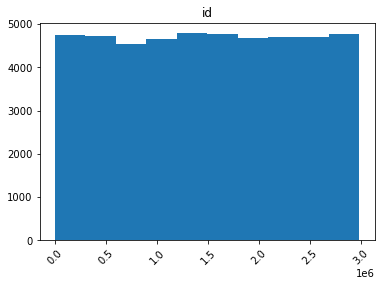

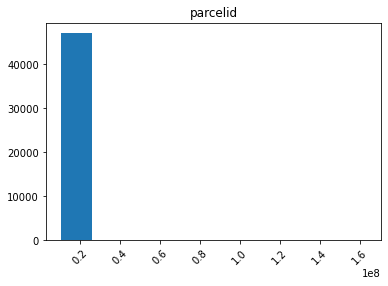

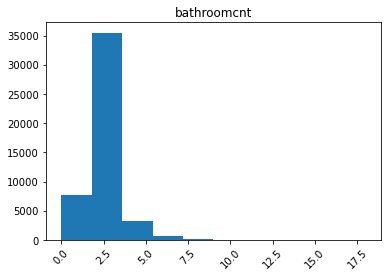

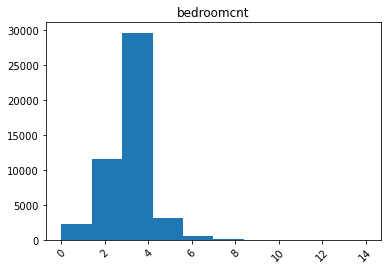

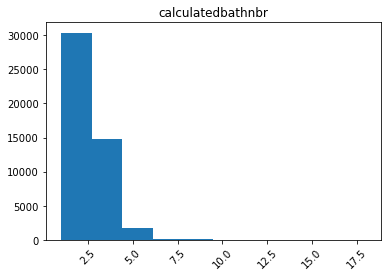

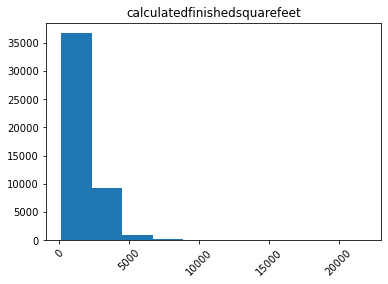

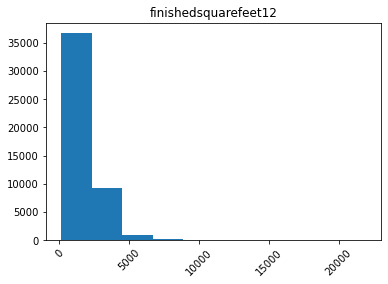

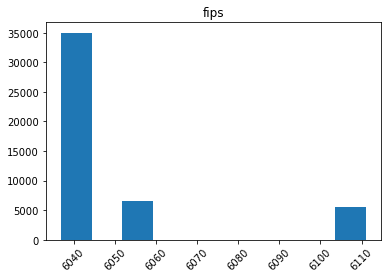

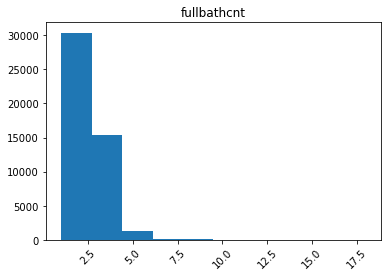

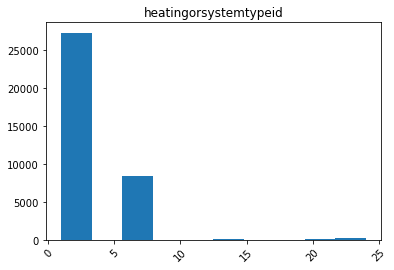

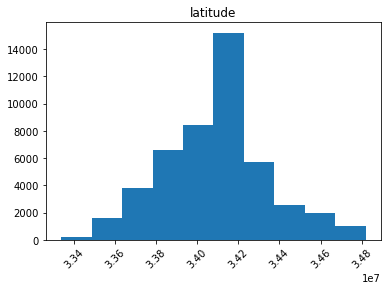

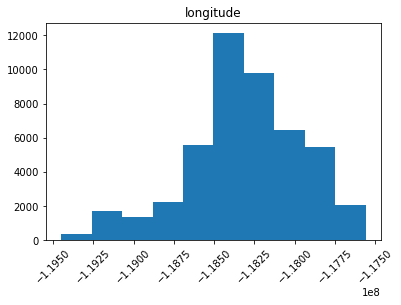

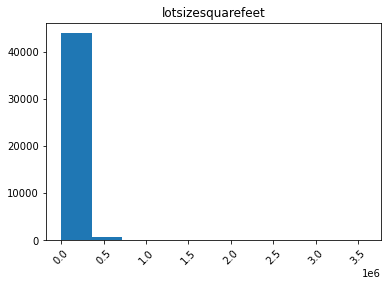

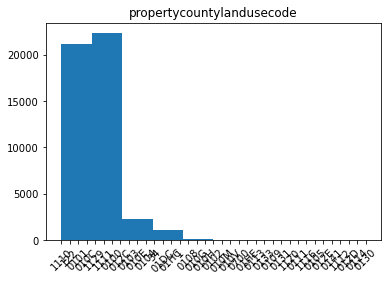

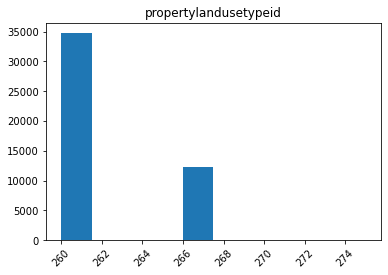

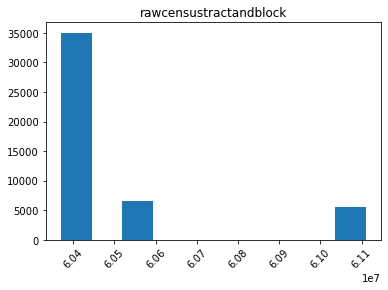

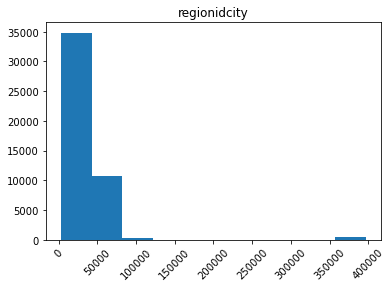

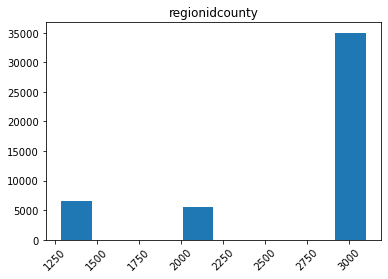

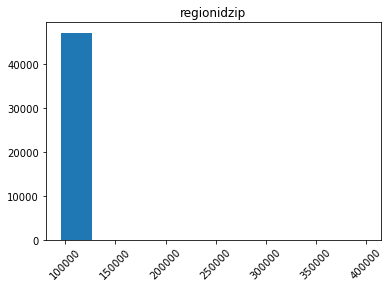

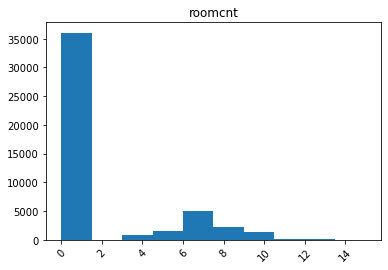

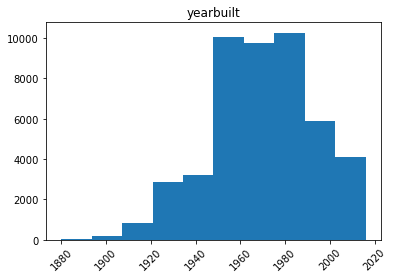

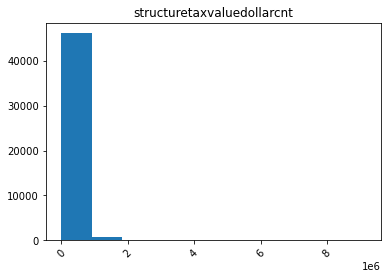

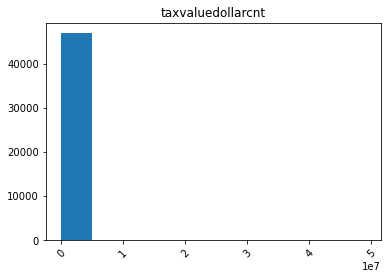

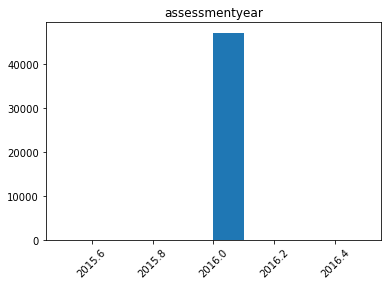

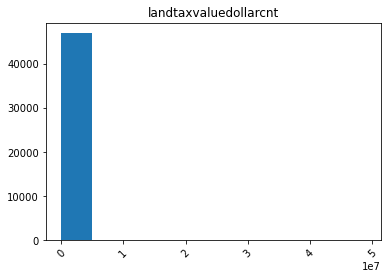

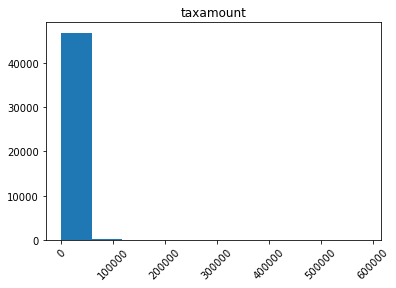

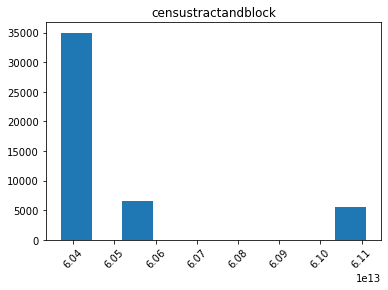

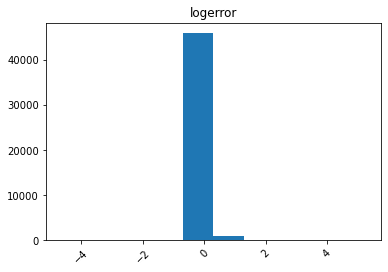

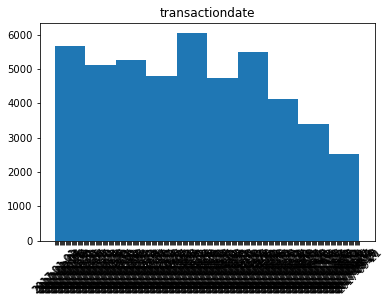

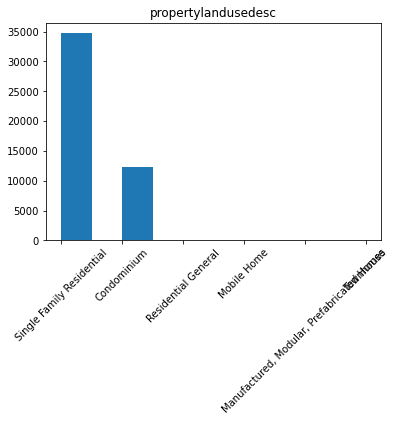

In [44]:
for col in df1.columns:
   
    # Title with columns name.
    plt.title(col)
    # histogram of each column 
    plt.hist(df1[col])
    plt.xticks(rotation=45)
    plt.show()

In [45]:
for col in df1.columns:
    print(col)
    print(df1[col].value_counts())
    print('------------------------')

id
1629305    2
539609     2
888220     2
1958785    2
2391496    2
          ..
31903      1
1469222    1
1672022    1
236321     1
1843709    1
Name: id, Length: 46980, dtype: int64
------------------------
parcelid
11391972    2
11061050    2
12641353    2
11733550    2
11917650    2
           ..
10922476    1
12481416    1
10726431    1
14438649    1
12773139    1
Name: parcelid, Length: 46980, dtype: int64
------------------------
bathroomcnt
2.0     19573
3.0     12206
1.0      7013
2.5      3081
4.0      2044
5.0       745
1.5       667
3.5       599
4.5       470
6.0       301
5.5       171
7.0        80
8.0        53
6.5        39
7.5        14
9.0        13
0.0         9
10.0        5
11.0        3
8.5         3
18.0        1
13.0        1
Name: bathroomcnt, dtype: int64
------------------------
bedroomcnt
3.0     18266
2.0     11481
4.0     11362
5.0      3083
1.0      2061
6.0       512
0.0       209
7.0        85
8.0        21
9.0         8
10.0        2
14.0        1
Nam

#### Takeaways:

- There are columns that have duplicated information:
    - square footage
    - propertylanduse
    - bathroom and bedroom counts
- Id is useless for our purposes so we can drop it
- Census information does not seem to be important for our intent. We can drop it
- assessment year it is all done at the same time.It can be dropped as well
- Address Outliers:
    - bedroom min is 0
    - bedroom max is 14
    - bathroom min is 0
    - batroom max is 18
    - calculatedfinishedsquarefeet	min is 152 sq. ft.	
    - calculatedfinishedsquarefeet max is 21,929 sq. ft.


### Remove columns

In [46]:
# drop columns not needed
cols_to_remove = ['id', 'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'roomcnt',
'propertycountylandusecode', 'propertylandusetypeid', 'censustractandblock', 'rawcensustractandblock', 'assessmentyear', 'heatingorsystemtypeid', 'regionidcity']

In [47]:
df1.drop(columns = cols_to_remove)
df1

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
1,1387261,17052889,1.0,2.0,1.0,1465.0,1465.0,6111.0,1.0,NaN,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,Single Family Residential
2,11677,14186244,2.0,3.0,2.0,1243.0,1243.0,6059.0,2.0,NaN,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,Single Family Residential
3,2288172,12177905,3.0,4.0,3.0,2376.0,2376.0,6037.0,3.0,2.0,...,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Single Family Residential
4,1970746,10887214,3.0,3.0,3.0,1312.0,1312.0,6037.0,3.0,2.0,...,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,Condominium
5,1447245,17143294,2.0,3.0,2.0,1492.0,1492.0,6111.0,2.0,NaN,...,1982.0,198640.0,331064.0,2016.0,132424.0,3508.10,6.111005e+13,-0.020526,2017-01-01,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77567,1373391,10722691,2.0,3.0,2.0,1570.0,1570.0,6037.0,2.0,2.0,...,1958.0,46784.0,72026.0,2016.0,25242.0,1000.70,6.037135e+13,0.081196,2017-09-19,Single Family Residential
77569,2864704,10833991,3.0,3.0,3.0,1741.0,1741.0,6037.0,3.0,2.0,...,1980.0,265000.0,379000.0,2016.0,114000.0,4685.34,6.037132e+13,-0.002245,2017-09-20,Condominium
77570,673515,11000655,2.0,2.0,2.0,1286.0,1286.0,6037.0,2.0,2.0,...,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Single Family Residential
77571,2968375,17239384,2.0,4.0,2.0,1612.0,1612.0,6111.0,2.0,NaN,...,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,Single Family Residential


#### Create a function to remove columns

In [48]:
def remove_columns(df, cols_to_remove):  
    df = df.drop(columns = cols_to_remove)
    return df

In [49]:
df1 = remove_columns(df1, cols_to_remove)

In [50]:
df1

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,propertylandusedesc
1,17052889,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,2061.0,97099.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01,Single Family Residential
2,14186244,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,1286.0,97078.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01,Single Family Residential
3,12177905,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,3101.0,96330.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01,Single Family Residential
4,10887214,3.0,3.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,3101.0,96451.0,1964.0,73681.0,119407.0,45726.0,1533.89,0.006940,2017-01-01,Condominium
5,17143294,2.0,3.0,1492.0,6111.0,34230044.0,-118993991.0,903.0,2061.0,97091.0,1982.0,198640.0,331064.0,132424.0,3508.10,-0.020526,2017-01-01,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77567,10722691,2.0,3.0,1570.0,6037.0,34194943.0,-118629218.0,7499.0,3101.0,96342.0,1958.0,46784.0,72026.0,25242.0,1000.70,0.081196,2017-09-19,Single Family Residential
77569,10833991,3.0,3.0,1741.0,6037.0,34202400.0,-118502000.0,59487.0,3101.0,96415.0,1980.0,265000.0,379000.0,114000.0,4685.34,-0.002245,2017-09-20,Condominium
77570,11000655,2.0,2.0,1286.0,6037.0,34245368.0,-118282383.0,47405.0,3101.0,96284.0,1940.0,70917.0,354621.0,283704.0,4478.43,0.020615,2017-09-20,Single Family Residential
77571,17239384,2.0,4.0,1612.0,6111.0,34300140.0,-118706327.0,12105.0,2061.0,97116.0,1964.0,50683.0,67205.0,16522.0,1107.48,0.013209,2017-09-21,Single Family Residential


#### Remove outliers

In [51]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,47091.0,1.272907e+07,2.384948e+06,1.071186e+07,1.122521e+07,1.206889e+07,1.389292e+07,1.629608e+08
bathroomcnt,47091.0,2.377057e+00,9.926356e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,47091.0,3.071181e+00,1.051462e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01
calculatedfinishedsquarefeet,47090.0,1.854487e+03,1.015471e+03,1.520000e+02,1.216000e+03,1.592000e+03,2.205000e+03,2.192900e+04
fips,47091.0,6.048741e+03,2.390831e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
latitude,47091.0,3.409057e+07,2.488790e+05,3.333953e+07,3.391510e+07,3.411498e+07,3.422161e+07,3.481877e+07
longitude,47091.0,-1.183097e+08,3.542417e+05,-1.194484e+08,-1.184900e+08,-1.183120e+08,-1.180810e+08,-1.175600e+08
lotsizesquarefeet,44798.0,3.680040e+04,1.113420e+05,2.360000e+02,6.160000e+03,7.953000e+03,1.786550e+04,3.589145e+06
regionidcounty,47091.0,2.726231e+03,6.672832e+02,1.286000e+03,2.061000e+03,3.101000e+03,3.101000e+03,3.101000e+03
regionidzip,47089.0,9.657261e+04,4.651153e+03,9.598200e+04,9.621000e+04,9.637300e+04,9.697100e+04,3.996750e+05


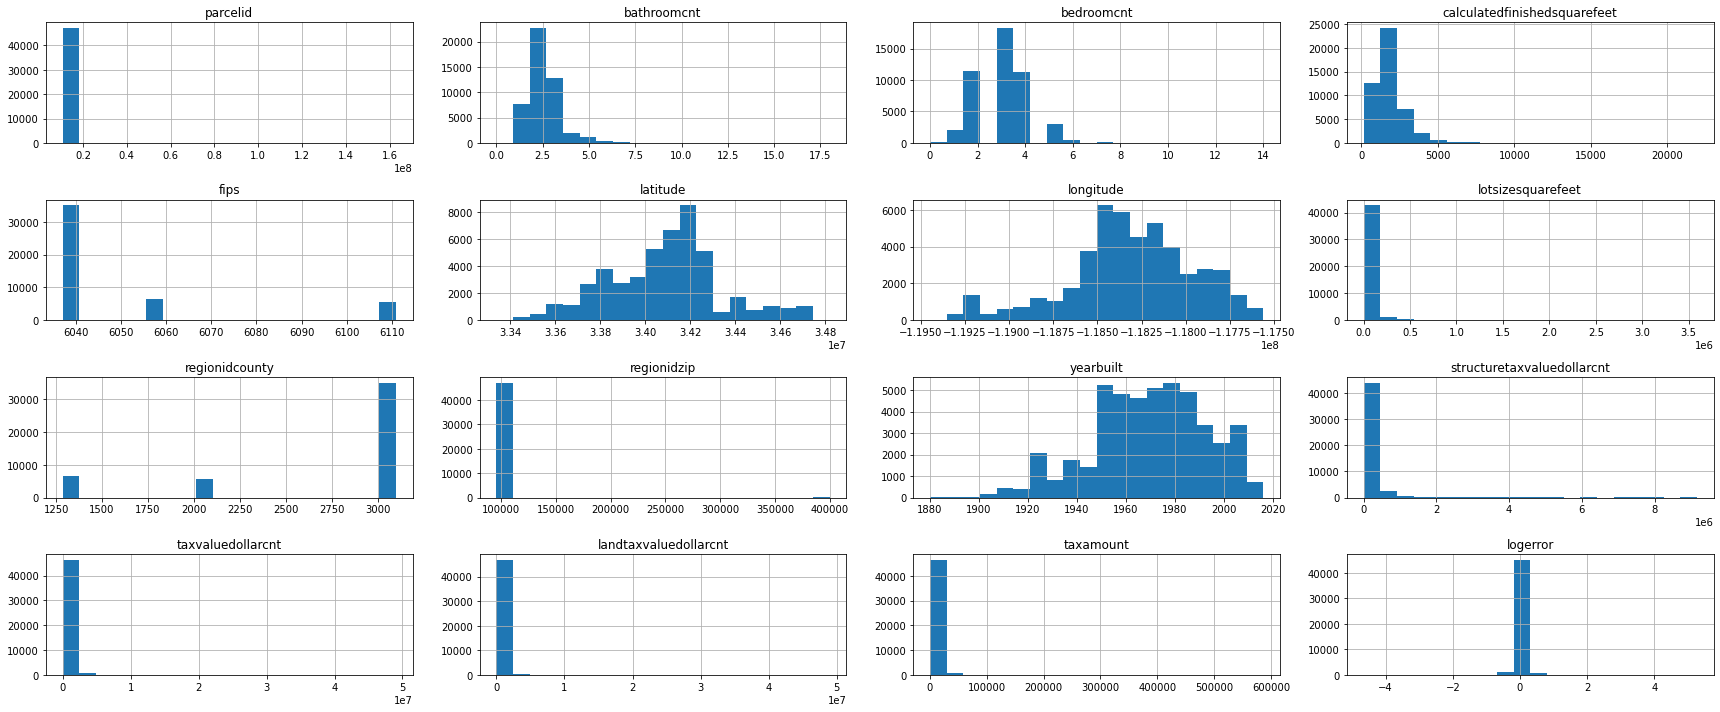

In [52]:
df1.hist(figsize=(24, 10), bins=20)
plt.tight_layout()

In [53]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47091 entries, 1 to 77572
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      47091 non-null  int64  
 1   bathroomcnt                   47091 non-null  float64
 2   bedroomcnt                    47091 non-null  float64
 3   calculatedfinishedsquarefeet  47090 non-null  float64
 4   fips                          47091 non-null  float64
 5   latitude                      47091 non-null  float64
 6   longitude                     47091 non-null  float64
 7   lotsizesquarefeet             44798 non-null  float64
 8   regionidcounty                47091 non-null  float64
 9   regionidzip                   47089 non-null  float64
 10  yearbuilt                     47072 non-null  float64
 11  structuretaxvaluedollarcnt    47071 non-null  float64
 12  taxvaluedollarcnt             47091 non-null  float64
 13  l

### Remove outliers, I will be removing only extreme outliers, since our goal is to find a driver of error

- bathroomcnt greater 1 and less than 7 will be an acceptable range
- bedroomcnt greater 1 and less than 7 will be an acceptable range
- calculatedfinishedsquarefeet 6,000 sq ft is too much to be a home but most properties will be undet that value  also anything under 350 sq ft is too small to be a home
- lotsizesquarefeet most data is less than 500,000
- regionidzip there is an error and added an extra digit all zipcodes are five digits so less than 100,000 is the best option
- structuretaxvaluedollarcnt majority of data is under 2 million
- taxvaluedollarcnt majority of data is under 2 million
- landtaxvaluedollarcnt majority of data is under 1.5 million
- taxamount majority of data is under 30 thousand

In [54]:
# add the values as conditions for the dataframe so that the outliers can be removed
df1[((df1.bathroomcnt <= 7) & (df1.bedroomcnt <= 7) &  
               (df1.bathroomcnt > 0) & 
               (df1.bedroomcnt > 0) & 
               (df1.calculatedfinishedsquarefeet > 350) & 
               (df1.calculatedfinishedsquarefeet < 6000) & 
               (df1.lotsizesquarefeet < 500_000) &
               (df1.regionidzip < 100_000) &
               (df1.structuretaxvaluedollarcnt < 1_000_000) &
               (df1.taxvaluedollarcnt < 2_000_000) &
               (df1.landtaxvaluedollarcnt < 1_500_000) &
               (df1.taxamount < 30_000)
              )]

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,propertylandusedesc
1,17052889,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,2061.0,97099.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01,Single Family Residential
2,14186244,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,1286.0,97078.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01,Single Family Residential
3,12177905,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,3101.0,96330.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01,Single Family Residential
4,10887214,3.0,3.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,3101.0,96451.0,1964.0,73681.0,119407.0,45726.0,1533.89,0.006940,2017-01-01,Condominium
5,17143294,2.0,3.0,1492.0,6111.0,34230044.0,-118993991.0,903.0,2061.0,97091.0,1982.0,198640.0,331064.0,132424.0,3508.10,-0.020526,2017-01-01,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77567,10722691,2.0,3.0,1570.0,6037.0,34194943.0,-118629218.0,7499.0,3101.0,96342.0,1958.0,46784.0,72026.0,25242.0,1000.70,0.081196,2017-09-19,Single Family Residential
77569,10833991,3.0,3.0,1741.0,6037.0,34202400.0,-118502000.0,59487.0,3101.0,96415.0,1980.0,265000.0,379000.0,114000.0,4685.34,-0.002245,2017-09-20,Condominium
77570,11000655,2.0,2.0,1286.0,6037.0,34245368.0,-118282383.0,47405.0,3101.0,96284.0,1940.0,70917.0,354621.0,283704.0,4478.43,0.020615,2017-09-20,Single Family Residential
77571,17239384,2.0,4.0,1612.0,6111.0,34300140.0,-118706327.0,12105.0,2061.0,97116.0,1964.0,50683.0,67205.0,16522.0,1107.48,0.013209,2017-09-21,Single Family Residential


#### Make a function to remove outliers

In [55]:
def remove_outliers(df):
    '''
    remove outliers in bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, lotsizesquarefeet,
    structuretaxvaluedollarcnt, taxvaluedollarcnt, landtaxvaluedollarcnt, taxamount
    '''

    return df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 7) &  
               (df.bathroomcnt > 0) & 
               (df.bedroomcnt > 0) & 
               (df.calculatedfinishedsquarefeet > 350) & 
               (df.calculatedfinishedsquarefeet < 6000) & 
               (df.lotsizesquarefeet < 500_000) &
               (df.regionidzip < 100_000) &
               (df.structuretaxvaluedollarcnt < 1_000_000) &
               (df.taxvaluedollarcnt < 2_000_000) &
               (df.landtaxvaluedollarcnt < 1_500_000) &
               (df.taxamount < 30_000)
              )]

In [56]:
df1 = remove_outliers(df1)

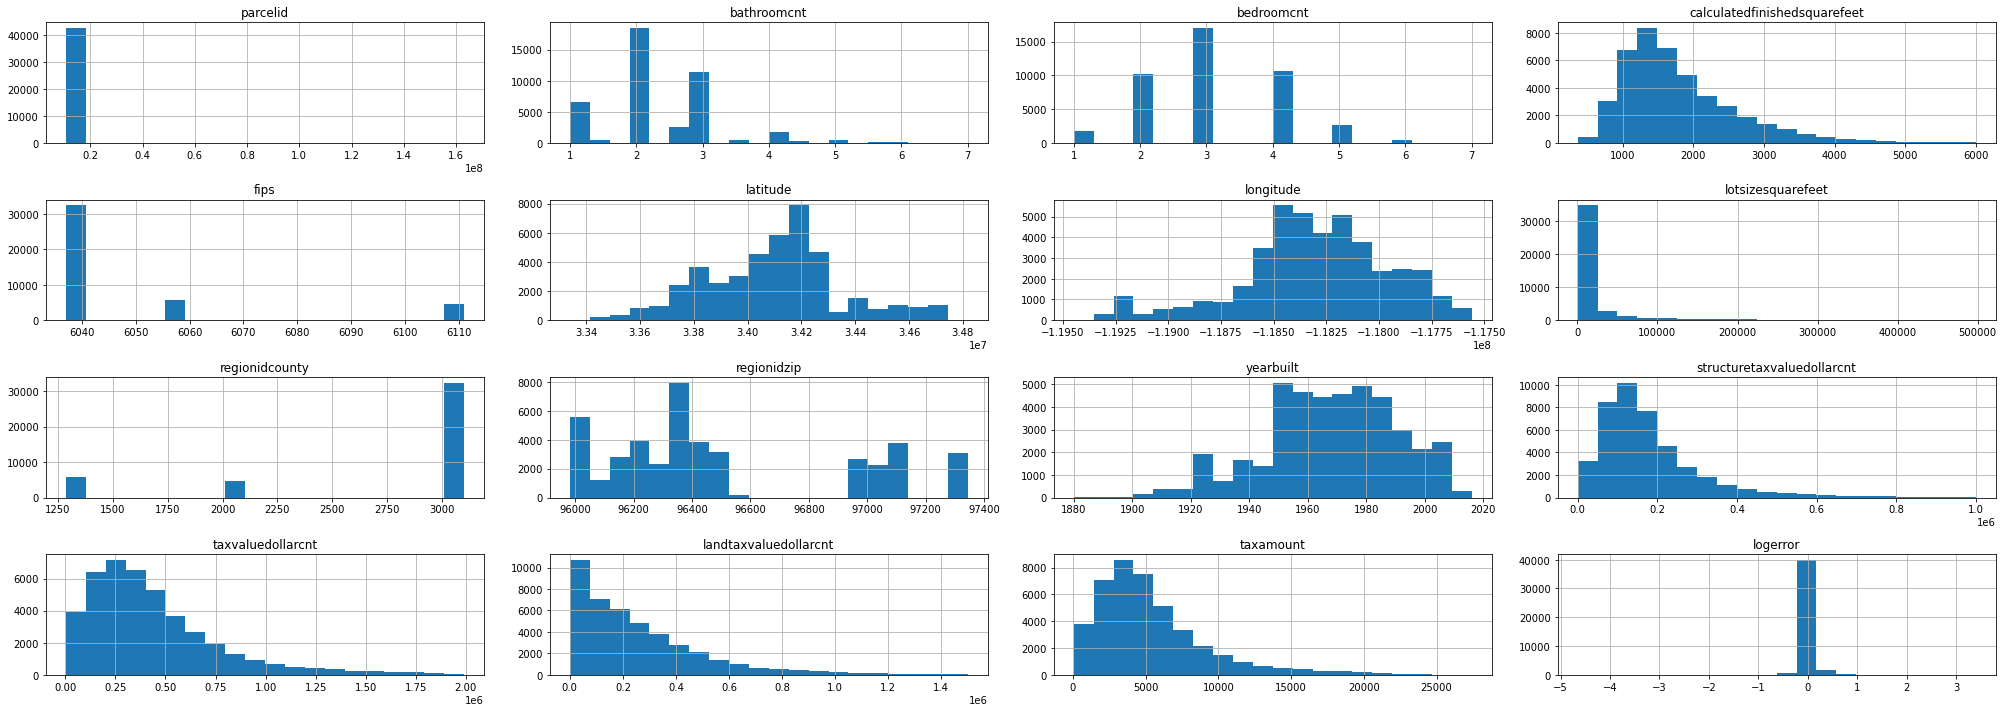

In [58]:
df1.hist(figsize=(28, 10), bins=20)
plt.tight_layout()

#### Add counties names based on fips columns.

In [59]:
df1['county'] = np.where(df1.fips == 6037, 'Los_Angeles', np.where(df1.fips == 6059, 'Orange', 'Ventura'))    

In [60]:
lot_median = df1.lotsizesquarefeet.median()
df1.lotsizesquarefeet.fillna(lot_median, inplace = True)

In [61]:
df1.shape

(42663, 19)

In [62]:
  df1 = df1.dropna()

In [63]:
df1.shape

(42647, 19)

#### Create a function to clean data

In [ ]:

def wrangle_zillow(df):

    # Get properties for single family 
    single_fam = [260, 261, 263, 266, 264, 275]
    df = df[df.propertylandusetypeid.isin(single_fam)]

    # Handle missing values i.e. drop columns and rows based on a threshold
    df = handle_missing_values(df)
        
    # drop columns not needed
    cols_to_remove = ['id', 'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'roomcnt','propertycountylandusecode', 
    'propertylandusetypeid', 'censustractandblock', 'rawcensustractandblock', 'assessmentyear', 'heatingorsystemtypeid', 'regionidcity']
    df = remove_columns(df, cols_to_remove)
    
    # Columns to look for outliers
    df = remove_outliers(df)
    
    # Add column for counties
    df['county'] = np.where(df.fips == 6037, 'Los_Angeles', np.where(df.fips == 6059, 'Orange', 'Ventura'))    

    # replace nulls with median values for select columns
    lot_median = df.lotsizesquarefeet.median()
    df.lotsizesquarefeet.fillna(lot_median, inplace = True)

    # Just to be sure we caught all nulls, drop them here
    df = df.dropna()
    return df

In [ ]:
df2 = get_zillow_data()
df2.shape

Reading from csv file...


(77574, 67)

In [ ]:
df2 = wrangle_zillow(df2)
df2.shape

(42663, 20)

In [ ]:
df2.county.value_counts()

Los_Angeles    32333
Orange          5690
Ventura         4640
Name: county, dtype: int64

In [ ]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,42663.0,1.266398e+07,2.389674e+06,1.071186e+07,1.120392e+07,1.206232e+07,1.307561e+07,1.629608e+08
bathroomcnt,42663.0,2.309988e+00,8.712593e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,7.000000e+00
bedroomcnt,42663.0,3.083257e+00,9.944559e-01,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,7.000000e+00
calculatedfinishedsquarefeet,42663.0,1.790117e+03,8.136462e+02,3.600000e+02,1.219000e+03,1.588000e+03,2.167000e+03,5.999000e+03
fips,42663.0,6.047982e+03,2.322753e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.037000e+03,6.111000e+03
latitude,42663.0,3.409622e+07,2.497252e+05,3.333953e+07,3.392187e+07,3.412050e+07,3.422490e+07,3.481877e+07
longitude,42663.0,-1.183030e+08,3.486285e+05,-1.194484e+08,-1.184830e+08,-1.183030e+08,-1.180796e+08,-1.175600e+08
lotsizesquarefeet,42663.0,2.802646e+04,6.091073e+04,2.360000e+02,6.102000e+03,7.781000e+03,1.596050e+04,4.974960e+05
regionidcity,41984.0,3.046312e+04,4.289001e+04,3.491000e+03,1.244700e+04,1.809800e+04,4.167300e+04,3.965560e+05
regionidcounty,42663.0,2.745822e+03,6.563890e+02,1.286000e+03,3.101000e+03,3.101000e+03,3.101000e+03,3.101000e+03


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42663 entries, 1 to 77572
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      42663 non-null  int64  
 1   bathroomcnt                   42663 non-null  float64
 2   bedroomcnt                    42663 non-null  float64
 3   calculatedfinishedsquarefeet  42663 non-null  float64
 4   fips                          42663 non-null  float64
 5   latitude                      42663 non-null  float64
 6   longitude                     42663 non-null  float64
 7   lotsizesquarefeet             42663 non-null  float64
 8   regionidcity                  41984 non-null  float64
 9   regionidcounty                42663 non-null  float64
 10  regionidzip                   42663 non-null  float64
 11  yearbuilt                     42647 non-null  float64
 12  structuretaxvaluedollarcnt    42663 non-null  float64
 13  t

In [ ]:
nulls_by_col(df2)

,number_missing_rows,percent_rows_missing
parcelid,0,0.000000
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
calculatedfinishedsquarefeet,0,0.000000
fips,0,0.000000
latitude,0,0.000000
longitude,0,0.000000
lotsizesquarefeet,0,0.000000
regionidcity,679,0.009436
regionidcounty,0,0.000000


## Split the data

In [ ]:
# split the data
train_validate, test = train_test_split(df2, test_size=.2, random_state=177)
train, validate = train_test_split(train_validate, test_size=.3, random_state=177)

train.shape, validate.shape, test.shape 

((18029, 21), (7728, 21), (6440, 21))

### Create a function to split the data

In [ ]:

def split_data(df):

    ''' this function will take your raw data frame, clean it and split it'''
    
    # split the data
    train_validate, test = train_test_split(df, test_size=.2, random_state=177)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=177)
    
    # show the split
    print(f'Dataframe has been split: ')
    print(f'Train: {train.shape}')
    print(f'Validate: {validate.shape}')
    print(f'Test: {test.shape}')
    
    # return train validate and test
    return train, validate, test 